In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import seaborn as sns

In [2]:
#read in files loaded to github. loaded them locally from kaggle to here since kaggle doesn't allow wget/direct downloads 
#except using the kaggle library
games=pd.read_csv("https://raw.githubusercontent.com/packagedjack/data/master/games.csv")
teams=pd.read_csv("https://raw.githubusercontent.com/packagedjack/data/master/teams.csv")
players=pd.read_csv("https://raw.githubusercontent.com/packagedjack/data/master/players.csv")
ranking=pd.read_csv("https://raw.githubusercontent.com/packagedjack/data/master/ranking.csv")


#gamedetails, split into 4 files due to 25 MB limit on github files
detail1=pd.read_csv("https://raw.githubusercontent.com/packagedjack/data/master/one_data.csv")
detail2=pd.read_csv("https://raw.githubusercontent.com/packagedjack/data/master/two_data.csv")
detail3=pd.read_csv("https://raw.githubusercontent.com/packagedjack/data/master/three_data.csv")
detail4=pd.read_csv("https://raw.githubusercontent.com/packagedjack/data/master/four_data.csv")


#create tuple of dataframes 
deets = (detail1,detail2,detail3,detail4)


#concat into single details dataframe
game_details = pd.concat(deets, ignore_index = True)

#remove unused previous index column
game_details = game_details.drop(['Unnamed: 0'], axis=1)

In [3]:
#build gamecomment DIM
game_comment_dim = game_details[["GAME_ID","TEAM_ID","PLAYER_ID","COMMENT"]].drop_duplicates().dropna()
game_comment_dim['COMMENT_ID'] = range(1, len(game_comment_dim) + 1)

In [4]:
position_dim = pd.DataFrame(game_details["START_POSITION"].drop_duplicates())
position_dim = position_dim.replace(np.nan, 'Bench', regex=True)
position_dim['POSITION_ID'] = range(1, len(position_dim) + 1)

In [5]:
#dims are position_dim, game_comment_dim, team_dim, player_team_season_dim, game_dim

#team_dim
team_dim = teams


In [6]:
#player_dim
#players
player_team_season_dim = players

In [7]:
#game_dim
games["GAME_DATE_EST"] = pd.to_datetime(games["GAME_DATE_EST"])
games["GAME_DATE_EST"] = games["GAME_DATE_EST"].dt.strftime('%Y%m%d').astype(int)
games["AWAY_TEAM_WINS"] = np.where(games["HOME_TEAM_WINS"] ==0,1,0)
game_dim = games.drop(["GAME_STATUS_TEXT"], axis=1)

In [8]:
#datedim
def create_date_table(start='2003-01-01', end='2020-12-31'):
    df = pd.DataFrame({"Date": pd.date_range(start, end)})
    df["Day"] = df.Date.dt.weekday_name
    df["Week"] = df.Date.dt.weekofyear
    df["Quarter"] = df.Date.dt.quarter
    df["Year"] = df.Date.dt.year
    df["Year_half"] = (df.Quarter + 1) // 2
    return df
date_dim = create_date_table()

In [9]:
conference_dim = ranking[["CONFERENCE"]].drop_duplicates().dropna()
conference_dim['Conference_ID'] = range(1, len(conference_dim) + 1)

In [10]:
#rankingfact
#dropped league_id and Conference, Team, W_PCT
ranking = pd.merge(ranking,conference_dim)
ranking_fact = ranking[["TEAM_ID","SEASON_ID","STANDINGSDATE","G","W","L","HOME_RECORD","ROAD_RECORD","Conference_ID"]]
ranking_fact[['HOME_WINS','HOME_LOSSES']] = ranking_fact.HOME_RECORD.str.split("-",expand=True) 
ranking_fact[['ROAD_WINS','ROAD_LOSSES']] = ranking_fact.ROAD_RECORD.str.split("-",expand=True) 
ranking_fact["STANDINGSDATE"] = pd.to_datetime(ranking_fact["STANDINGSDATE"])
ranking_fact["STANDINGSDATE"] = ranking_fact["STANDINGSDATE"].dt.strftime('%Y%m%d')
ranking_fact = ranking_fact.drop(["ROAD_RECORD","HOME_RECORD"], axis=1)

In [11]:
#drop all percentage calculations, dimension type columns. can build calculations on the fly, any details will be stored
#in dimension tables
game_details_fact = game_details[["GAME_ID","TEAM_ID","PLAYER_ID",'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS']]

#this entire block is devoted to converting the string column of time on floor
#messy but effective

game_details_fact["MIN"]  = game_details_fact["MIN"].astype(str)
game_details_fact["MIN"] = game_details_fact["MIN"].replace('nan', 0, regex=True)
game_details_fact["MIN"] = game_details_fact["MIN"].fillna(0)
game_details_fact[['Minutes','Seconds']] = game_details_fact.MIN.str.split(":",expand=True) 


game_details_fact["Seconds"]  = game_details_fact["Seconds"].astype(str)
game_details_fact["Seconds"] = game_details_fact["Seconds"].replace('nan', 0, regex=True)
game_details_fact["Seconds"] = game_details_fact["Seconds"].fillna(0)
game_details_fact["Seconds"] = game_details_fact["Seconds"].replace('None', 0, regex=True)


game_details_fact["Minutes"]  = game_details_fact["Minutes"].astype(str)
game_details_fact["Minutes"] = game_details_fact["Minutes"].replace('nan', 0, regex=True)
game_details_fact["Minutes"] = game_details_fact["Minutes"].replace('None', 0, regex=True)
game_details_fact["Minutes"] = game_details_fact["Minutes"].fillna(0)


In [12]:
game_details_fact["TIME_ON_FLOOR"] = ((game_details_fact["Minutes"].astype(int) * 60) + game_details_fact["Seconds"].astype(int))
game_details_fact = game_details_fact.replace('None', 0, regex=True)
game_details_fact = game_details_fact.replace('nan', 0, regex=True)
game_details_fact = game_details_fact.fillna(0)
game_details_fact = game_details_fact.drop(["Minutes","Seconds","MIN"], axis=1)
game_fact = game_details_fact

In [13]:
game_fact = game_details_fact
game_fact.head(2)

,GAME_ID,TEAM_ID,PLAYER_ID,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,TIME_ON_FLOOR
0,21900504,1610612753,1628411,4.0,7.0,0.0,1.0,2.0,2.0,1.0,5.0,6.0,1.0,1.0,0.0,1.0,3.0,10.0,13.0,1321
1,21900504,1610612753,1628371,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,123


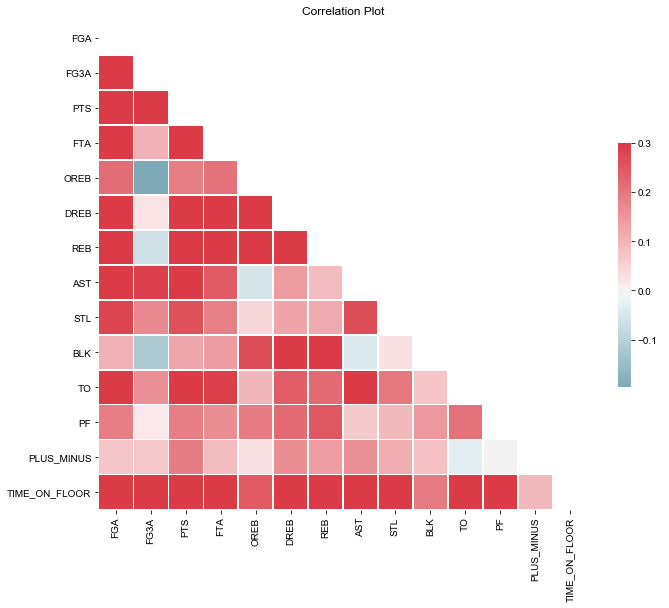

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

#lets look at player games where at least one point was scored
df = game_fact[game_fact["PTS"]>0]

corr = df[['FGA', 'FG3A', "PTS",
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',
       'PLUS_MINUS', 'TIME_ON_FLOOR']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)


ax = plt.axes()

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,ax = ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.set(rc={'figure.figsize':(5.7,8.27)})
ax.set_title('Correlation Plot')
plt.show()

In [15]:
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.model_selection import train_test_split

#lets remove field goals and free throws made
X = df[['FGA', 'FG3A', 
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',
       'PLUS_MINUS', 'TIME_ON_FLOOR']]  #independent columns
y = df.PTS

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)


In [16]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)
#df.PTS

0.8236412890825023

In [17]:
y_pred = reg.predict(X_test)

In [18]:
test = df
preds = reg.predict(test[['FGA', 'FG3A', 
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',
       'PLUS_MINUS', 'TIME_ON_FLOOR']])
test["PTS"] = y
test["PRED_POINTS"] = preds
test["PRED_DIFF"] = test["PTS"] - test["PRED_POINTS"]
test["PerformanceHue"] = np.where(test["PRED_DIFF"]<0,0,1)
#test.head()

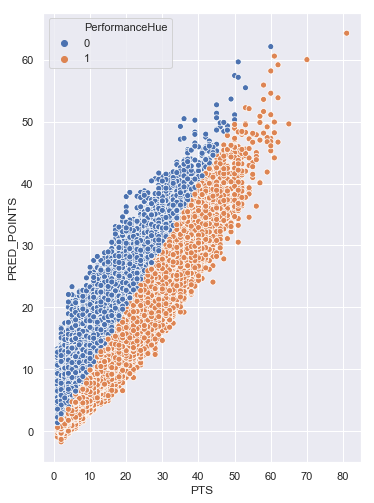

In [19]:
sns.scatterplot(x="PTS", y="PRED_POINTS", data=test, hue = "PerformanceHue")
#test[test["SEASON"]==2019]

In [20]:
Output = test[test["TEAM_ID"]==1610612765]
Output = pd.merge(Output,player_team_season_dim)


In [21]:
Output = pd.merge(test[test["TEAM_ID"]==1610612765],game_dim)
Output = pd.merge(Output,player_team_season_dim[player_team_season_dim["SEASON"]==2019])
Output = Output[Output["SEASON"]==2019]
Output = pd.merge(Output,game_dim)
Output = Output[["GAME_ID","PLAYER_NAME","PRED_DIFF","PTS","PRED_POINTS","GAME_DATE_EST"]]
Output.sort_values("PRED_DIFF",ascending = True).to_excel("Output_Pistons.xlsx")